In [1]:
from typing import Optional, Tuple, Union
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import json
from collections import defaultdict
from dataclasses import dataclass

from transformers import LayoutLMv2Processor, LayoutLMv2ImageProcessor
from transformers import LayoutLMv2PreTrainedModel, LayoutLMv2Model
from transformers.utils import ModelOutput
from transformers.modeling_outputs import TokenClassifierOutput
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
import pandas as pd
import numpy as np
from datasets import Dataset



import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss



In [2]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def unnormalize_ls_box(bbox, width, height):
     return [
         width * (bbox[0] / 100),
         height * (bbox[1] / 100),
         width * (bbox[2] / 100),
         height * (bbox[3] / 100),
     ]

In [3]:
def draw_boxes(img: Image, boxes, norm = True):
  draw = ImageDraw.Draw(img)

  width, height = img.size

  for box in boxes:
    print(box)
    # if norm:
    box = unnormalize_ls_box(box, width, height)
    draw.rectangle(box, outline="blue", width=2)

In [4]:
# Original yt dataset
# COCO_PATH = Path("../datasets/custom_youtube/white_bg/export/2024-03-13-20-58") # using just for images, since their names are "mangled" by lable studio
# ANNOT_PATH = Path("../datasets/custom_youtube/white_bg/export/min-project-4-at-2024-03-13-19-53-af410d9e.json") # these are the actual annotations

# COCO_PATH = Path("../datasets/custom_youtube/white_bg/export2/2024-04-10-17-08") # using just for images, since their names are "mangled" by lable studio
# ANNOT_PATH = Path("../datasets/custom_youtube/white_bg/export2/min-project-4-at-2024-04-10-17-08-7e62dd88.json") # these are the actual annotations

COCO_PATH = Path("../datasets/custom_youtube/white_bg/export3/2024-04-16-01-16-e02f37d2/") # using just for images, since their names are "mangled" by lable studio
ANNOT_PATH = Path("../datasets/custom_youtube/white_bg/export3/min-project-4-at-2024-04-16-01-16-e02f37d2.json") # these are the actual annotations

In [5]:
def make_bbox(rect):
  return [rect["x"], rect["y"], rect["x"] + rect["width"], rect["y"] + rect["height"]]


cls2id = {
  "O": 0,
  "Body": 1,
  "Author": 2,
  "Date": 3
}
labels = list(cls2id.keys())

def prepare_annotations(path: Path):


  d = defaultdict(lambda: { "bbox": [], "image": None })

  with open(path, "r") as f:
    results = json.load(f)
    print(results)
    print(results[0].keys())

  for annot in results:
    for b in annot["label"]:
      d[annot["id"]]["bbox"].append({ "box": make_bbox(b), "class_id": cls2id[b["rectanglelabels"][0]] })
    d[annot["id"]]["image"] = annot["image"].split("/")[-1]

  # for img in results["images"]:
  #   d[img["id"]]["image"] = img["file_name"].split("/")[1]

  # print(d)

  classes = {}
  for n,i in cls2id.items():
    classes[i] = n

  return (d, classes)


annots, id2cls = prepare_annotations(ANNOT_PATH)

[{'image': '/data/upload/4/613b5c04-yt_big_1.png', 'id': 8, 'label': [{'x': 10.387323943661972, 'y': 4.106606854240195, 'width': 45.86267605633803, 'height': 2.8746247979681367, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.380281690140844, 'y': 17.384635682950158, 'width': 8.18661971830986, 'height': 3.148398588250817, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.29225352112676, 'y': 27.651152818550646, 'width': 80.36971830985917, 'height': 2.60085100768546, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.380281690140844, 'y': 37.91766995415114, 'width': 7.922535211267604, 'height': 2.4639641125441187, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.556338028169016, 'y': 47.773526404327605, 'width': 20.686619718309856, 'height': 2.6008510076854563, 'rotation': 0, 'rec

In [6]:
# TODO: i don't think this works properly right now
def calculate_iou(box1, box2):
    x0_inter = max(box1[0], box2[0])
    y0_inter = max(box1[1], box2[1])
    x1_inter = min(box1[2], box2[2])
    y1_inter = min(box1[3], box2[3])
    
    if x1_inter < x0_inter or y1_inter < y0_inter:
        return 0.0
    
    intersection_area = (x1_inter - x0_inter) * (y1_inter - y0_inter)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area
    
    return iou

In [7]:
anot = annots[8]
img = Image.open(COCO_PATH / "images" / anot["image"]).convert("RGB")


def classify_bboxes(img: Image, encoding, anot):

  width, height = img.size

  ner_tags  = []
  for i,box in enumerate(encoding.boxes[0]):
    ner_tags.append(0)

    for block in anot["bbox"]:
      iou = calculate_iou(unnormalize_ls_box(block["box"], width, height), unnormalize_box(box, width, height)) # TODO: fix iou -- don't think it works

      if iou > 0: # there is some overlap -- mark it with that label (iou doesn't seem to work properly...)
        ner_tags[i] = block["class_id"]

  return ner_tags

In [8]:
id2color = {
  0: "black",
  1: "green",
  2: "blue",
  3: "yellow"
}

### Create dataset

In [9]:


def make_dataset(annots):
  words = []
  boxes = []
  images = []
  word_labels = []
  start_end = []
  parent_rels = []

  processor = LayoutLMv2ImageProcessor.from_pretrained("microsoft/layoutlmv2-base-uncased")

  for id,val in annots.items():

    image = Image.open(COCO_PATH / "images" / val["image"]).convert("RGB")

    # TODO: could this be done for all images at one time?
    encoding = processor(image, return_tensors="pt")  # you can also add all tokenizer parameters here such as padding, truncation
    
    ner_tags = classify_bboxes(image, encoding, val)

    start_end_local = []
    inside = False
    last = ""
    for c in ner_tags:
      if c == cls2id["Author"] and not inside:
        inside = True
        start_end_local.append(1) # start of comment
      elif c == cls2id["O"] and last == cls2id["Body"] and inside:
        start_end_local[-1] = 2 # end of comment (is the previous word)
        start_end_local.append(0) # current one should be ignored
        inside = False
      else:
        start_end_local.append(0) # ignore -- inside of comment
      last = c
    start_end.append(start_end_local)

    print(start_end_local)

    # parent_rels.append(annot_rels[id])

    words.append(encoding.words[0])
    boxes.append(encoding.boxes[0])
    images.append(val["image"])
    word_labels.append(ner_tags)

    print(val["image"])




  ds = Dataset.from_pandas(pd.DataFrame({ 
    "image": images,
    "words": words,
    "boxes": boxes,
    "word_labels": word_labels,
    "id": id,
    "start_end": start_end,
    # "parent_rels": parent_rels
  }))

  return ds

# make_dataset(annots)

In [10]:
annots, id2cls_dict = prepare_annotations(ANNOT_PATH)

ds = make_dataset(annots)
ds

[{'image': '/data/upload/4/613b5c04-yt_big_1.png', 'id': 8, 'label': [{'x': 10.387323943661972, 'y': 4.106606854240195, 'width': 45.86267605633803, 'height': 2.8746247979681367, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.380281690140844, 'y': 17.384635682950158, 'width': 8.18661971830986, 'height': 3.148398588250817, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.29225352112676, 'y': 27.651152818550646, 'width': 80.36971830985917, 'height': 2.60085100768546, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.380281690140844, 'y': 37.91766995415114, 'width': 7.922535211267604, 'height': 2.4639641125441187, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.556338028169016, 'y': 47.773526404327605, 'width': 20.686619718309856, 'height': 2.6008510076854563, 'rotation': 0, 'rec

Dataset({
    features: ['image', 'words', 'boxes', 'word_labels', 'id', 'start_end'],
    num_rows: 13
})

In [11]:
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=labels)),
    'start_end_labels': Sequence(ClassLabel(names=labels)),
    # 'parent_rels': Sequence(Value(dtype='int64')),
})

# def preprocess_data(boxes, words, ner_tags, img_path):
def preprocess_data(examples):
  print("ex:", (examples["words"]))
  image = [Image.open(COCO_PATH / "images" / path).convert("RGB") for path in examples["image"]]
  # image = Image.open(COCO_PATH / "images" / examples["image"]).convert("RGB")
  # words = words
  # boxes = boxes
  # word_labels = ner_tags
  
  encoded_inputs = processor(image, examples["words"], boxes=examples["boxes"], word_labels=examples["word_labels"], stride=128,
                             padding="max_length", truncation=True, max_length=512, return_overflowing_tokens=True, return_offsets_mapping=True)
  print(encoded_inputs.keys())

  offset_mapping = encoded_inputs.pop('offset_mapping')
  overflow_to_sample_mapping = encoded_inputs.pop('overflow_to_sample_mapping')

  encoded_inputs_start_end = processor(image, examples["words"], boxes=examples["boxes"], word_labels=examples["start_end"], stride=128,
                             padding="max_length", truncation=True, max_length=512, return_overflowing_tokens=True, return_offsets_mapping=True)
  # encoded_inputs_start_end = encoded_inputs.pop('offset_mapping')
  # overflow_to_sample_mapping = encoded_inputs.pop('overflow_to_sample_mapping')

  encoded_inputs["start_end_labels"] = encoded_inputs_start_end["labels"]
  # encoded_inputs["parent_rels"] = examples["parent_rels"]
  
  return encoded_inputs

# train_dataset = datasets['train'].map(preprocess_data, batched=True, remove_columns=datasets['train'].column_names,
#                                       features=features)


train_dataset = ds.map(preprocess_data, batched=True, features=features, batch_size=5, remove_columns=ds.column_names)

train_dataset.set_format(type="torch")

# sample = preprocess_data(encoding.boxes[0], encoding.words[0], ner_tags, anot["image"])

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

ex: [['9', '@Jonathandelarosa1199', '1', 'month', 'ago', "There's", 'something', 'adorable', 'about', 'little', 'Sam', 'call', 'ty', 'DB', 'reply', '1g', 'Matt', 'and', 'Marisha,', 'Mr.', 'Matt', 'and', 'Ms.', 'Marisha.', '*', '4replies', 'e', '@SLorraineE', '1', 'month', 'ago', 'Yes!!!', 'So', 'cute!', 'Oe', 'GB', 'Reply', '@', '@DragonElixion', '1', 'month', 'ago', 'Look...', 'l', 'thought', 'the', 'same', 'thing', 'too...', 'then', '|', 'remembered', 'that', 'a', 'few', 'episodes', 'back', 'Marisha', 'suggested', 'it', 'was', 'the', 'start', 'of', 'their', 'throuple...', 'and', 'now', 'I', "don't", 'know', 'how', 'to', 'feel.', 'oe', 'BF', 'Reply', '6', '@Shakeandbake1990', '1', 'month', 'ago', 'Itwas', 'adorable', 'OP', 'Reply', '2', '@Grifter-2005', '1', 'month', 'ago', 'It', 'was', 'cute', 'until', 'big', 'Sam', 'said', 'miss', 'Marisha', 'oe', 'BF', 'Reply', '@GrayArmyGaming', '1', 'month', 'ago', '(edited)', 'Yes!ll!', "Sam's", "son's", 'imitation', 'of', 'Sam', 'was', 'brillia

In [12]:
len(train_dataset)

17

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=2)

In [14]:
# batch = next(iter(train_dataloader))

# for k,v in batch.items():
#   print(k, v.shape)

### Custom LayoutLMv2 model

In [15]:

@dataclass
class TokenClassifier2Output(ModelOutput):
    """
    Base class for outputs of token classification models.

    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `labels` is provided) :
            Classification loss.
        logits (`torch.FloatTensor` of shape `(batch_size, sequence_length, config.num_labels)`):
            Classification scores (before SoftMax).
        hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.
        attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    """

    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    start_end_logits: torch.FloatTensor = None
    parent_rels_logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None



class LayoutLMv2ForCustomClassification(LayoutLMv2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.layoutlmv2 = LayoutLMv2Model(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.start_end_classifier = nn.Linear(config.hidden_size, 3)
        # self.par_rel1 = nn.Conv2d(1, 2)
        # self.par_rel2 = nn.Conv2d(2, 1)
        self.par_rel1 = nn.Linear(7, 50)
        self.par_rel2 = nn.Linear(50, 100)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.layoutlmv2.embeddings.word_embeddings

    # @add_start_docstrings_to_model_forward(LAYOUTLMV2_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    # @replace_return_docstrings(output_type=TokenClassifierOutput, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        bbox: Optional[torch.LongTensor] = None,
        image: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        start_end_labels: Optional[torch.LongTensor] = None, # NOTE: Added
        parent_rels: Optional[torch.LongTensor] = None, # NOTE: Added
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.

        Returns:

        Example:

        ```python
        >>> from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification, set_seed
        >>> from PIL import Image
        >>> from datasets import load_dataset

        >>> set_seed(88)

        >>> datasets = load_dataset("nielsr/funsd", split="test")
        >>> labels = datasets.features["ner_tags"].feature.names
        >>> id2label = {v: k for v, k in enumerate(labels)}

        >>> processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")
        >>> model = LayoutLMv2ForTokenClassification.from_pretrained(
        ...     "microsoft/layoutlmv2-base-uncased", num_labels=len(labels)
        ... )

        >>> data = datasets[0]
        >>> image = Image.open(data["image_path"]).convert("RGB")
        >>> words = data["words"]
        >>> boxes = data["bboxes"]  # make sure to normalize your bounding boxes
        >>> word_labels = data["ner_tags"]
        >>> encoding = processor(
        ...     image,
        ...     words,
        ...     boxes=boxes,
        ...     word_labels=word_labels,
        ...     padding="max_length",
        ...     truncation=True,
        ...     return_tensors="pt",
        ... )

        >>> outputs = model(**encoding)
        >>> logits, loss = outputs.logits, outputs.loss

        >>> predicted_token_class_ids = logits.argmax(-1)
        >>> predicted_tokens_classes = [id2label[t.item()] for t in predicted_token_class_ids[0]]
        >>> predicted_tokens_classes[:5]
        ['B-ANSWER', 'B-HEADER', 'B-HEADER', 'B-HEADER', 'B-HEADER']
        ```
        """

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.layoutlmv2(
            input_ids=input_ids,
            bbox=bbox,
            image=image,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]
        # only take the text part of the output representations
        sequence_output = outputs[0][:, :seq_length]
        sequence_output = self.dropout(sequence_output)

        # print(sequence_output.size())

        logits = self.classifier(sequence_output)

        
        start_end_logits = self.start_end_classifier(sequence_output) # TODO: try using the image outputs also?

        # print(seq_length)
        # print(logits.size())
        # print(start_end_logits.size())



        # both_logits = torch.cat((logits, start_end_logits), dim=2)
        # print(both_logits.size())

        # rel_logits1 = self.par_rel1(both_logits)
        # rel_logits = self.par_rel2(rel_logits1)

        # print(rel_logits.size())



        loss = None
        if labels is not None and start_end_labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            loss_start_end = loss_fct(start_end_logits.view(-1, 3), start_end_labels.view(-1))
            # print(start_end_logits.view(-1, 3).size(), start_end_labels.size())
            # print(rel_logits.view(seq_length, -1).size(), parent_rels.view(-1).size())
            # loss_rel = MSELoss()(rel_logits.view(seq_length, -1).float(), parent_rels.view(-1).float())
            # loss = (loss + loss_start_end + (loss_rel/2)) / 3
            loss = (loss + loss_start_end) / 2
        elif labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifier2Output(
            loss=loss,
            logits=logits,
            start_end_logits=start_end_logits,
            parent_rels_logits=None,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


### Train the model

In [ ]:
import gc
model = None
trainer = None
gc.collect()

In [16]:
check_point_name = "layoutlmv2-finetuned-window"

In [17]:

# copied from Fine_tuning_LayoutLMv2ForToeknClassification_on_FUNSD_using_HuggingFace_Trainer.ipynb
from transformers import LayoutLMv2ForTokenClassification, TrainingArguments, Trainer
from datasets import load_metric
import numpy as np


# torch.cuda.empty_cache()

model = LayoutLMv2ForCustomClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                                      num_labels=len(cls2id))

# Set id2label and label2id 
model.config.id2label = id2cls_dict
model.config.label2id = cls2id

# Metrics
metric = load_metric("seqeval")
return_entity_level_metrics = True

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2cls_dict[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2cls_dict[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

class CommentTrainer(Trainer):
    def get_train_dataloader(self):
      return train_dataloader

    def get_test_dataloader(self, test_dataset):
    #   return test_dataloader
      return train_dataloader

# torch.cuda.set_device(0)

args = TrainingArguments(
    output_dir=check_point_name, # dir to store checkpoints
    max_steps=1000,
    warmup_ratio=0.1, # small warmup
    fp16=True, # mixed precision (less memory) -- requires CUDA
    push_to_hub=False, 
)

# model = model.to(args.device)

# Initialize our Trainer
trainer = CommentTrainer(
    model=model,
    args=args,
    compute_metrics=compute_metrics,
)

torch.cuda.empty_cache()

Some weights of LayoutLMv2ForCustomClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'par_rel1.bias', 'par_rel1.weight', 'par_rel2.bias', 'par_rel2.weight', 'start_end_classifier.bias', 'start_end_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_652656/4133533349.py:17: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/home/filip/fit/mit/s2/knn/project/venv/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com

In [18]:
trainer.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/filip/fit/mit/s2/knn/project/venv/lib/python3.10/site-packages/detectron2/layers/wrappers.py:127: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  x = F.conv2d(


{'loss': 0.3344, 'grad_norm': 0.21106170117855072, 'learning_rate': 2.777777777777778e-05, 'epoch': 55.56}
{'loss': 0.0846, 'grad_norm': 0.13586486876010895, 'learning_rate': 0.0, 'epoch': 111.11}
{'train_runtime': 1019.5931, 'train_samples_per_second': 7.846, 'train_steps_per_second': 0.981, 'train_loss': 0.20949258804321289, 'epoch': 111.11}


TrainOutput(global_step=1000, training_loss=0.20949258804321289, metrics={'train_runtime': 1019.5931, 'train_samples_per_second': 7.846, 'train_steps_per_second': 0.981, 'train_loss': 0.20949258804321289, 'epoch': 111.11})

In [18]:
trainer.save_model()

## Inference

In [20]:
from transformers import AutoModelForTokenClassification

# model = AutoModelForTokenClassification.from_pretrained("./layoutlmv2-finetuned-yt-v2/checkpoint-1000")
# model = LayoutLMv2ForCustomClassification.from_pretrained("./layoutlmv2-finetuned-yt-group2-v2/checkpoint-1000")
model = LayoutLMv2ForCustomClassification.from_pretrained(check_point_name + "/checkpoint-1000")

In [21]:
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

In [146]:
img_path = Path("../datasets/custom_youtube/white_bg/data/yt_new_big_1.png")
# img_path = Path("../datasets/custom_youtube/white_bg/data/yt_huge_1.png")
# img_path = Path("../datasets/custom_youtube/white_bg/export3/2024-04-16-01-16-e02f37d2/images/7173c475-2.png")
# img_path = Path("../datasets/custom_sz/sz_1.png")
# img_path = Path("../datasets/custom/novinky_1_large_p1_2.png")
# img_path = Path("../datasets/custom/sk_dennikn_1.png")
image = Image.open(
        img_path
).convert("RGB")

width, height = image.size

In [95]:
encoding = processor(
    image, return_tensors="pt", return_offsets_mapping=True, truncation=True, stride=128, padding="max_length", max_length=512, return_overflowing_tokens=True
)  # you can also add all tokenizer parameters here such as padding, truncation
print(encoding.keys())

offset_mapping = encoding.pop('offset_mapping')
overflow_to_sample_mapping = encoding.pop('overflow_to_sample_mapping')
print(encoding.keys())
print(len(encoding.bbox[0]))
print(len(encoding.bbox))
# print(len(encoding["input_ids"][0]))
# encoding.to("cuda") # can move to GPU -- have to move both encoding and the model below

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'bbox', 'image'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])
512
1


In [31]:
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([1, 512])
token_type_ids torch.Size([1, 512])
attention_mask torch.Size([1, 512])
bbox torch.Size([1, 512, 4])


AttributeError: 'list' object has no attribute 'shape'

### Handle split documents

In [96]:
x = []
for i in range(0, len(encoding['image'])):
     x.append(encoding['image'][i])
x = torch.stack(x)
encoding['image'] = x

In [97]:
# model = model.to("cuda")
with torch.no_grad():
  outputs = model(**encoding)

In [98]:
print(outputs.logits.shape)

predictions = outputs.logits.argmax(-1).squeeze().tolist()
start_end_predictions = outputs.start_end_logits.argmax(-1).squeeze().tolist()
# rel_predictions = outputs.parent_rels_logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

print(predictions)
print(token_boxes)

# is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

# true_predictions = [id2cls_dict[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
# true_start_end_predictions = [pred for idx, pred in enumerate(start_end_predictions) if not is_subword[idx]]
# # true_rel_predictions = [pred for idx, pred in enumerate(rel_predictions) if not is_subword[idx]]
# true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

# print(true_predictions)
# print(true_start_end_predictions)
# print(true_boxes)    
# print(len(rel_predictions), rel_predictions)
# print(len(true_rel_predictions), true_rel_predictions)

torch.Size([1, 512, 4])
[1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [99]:
true_predictions =[]
true_boxes = []
true_start_end_predictions = []

if outputs.logits.shape[0] != 1:
    STRIDE_COUNT = 128
    for i, (pred, box, mapped) in enumerate(zip(predictions, token_boxes, offset_mapping)):
        is_subword = np.array(mapped.squeeze().tolist())[:,0] != 0
        if i == 0:
            true_predictions += [id2cls[pred_] for idx, pred_ in enumerate(pred) if (not is_subword[idx])]
            true_boxes += [unnormalize_box(box_, width, height) for idx, box_ in enumerate(box) if not is_subword[idx]]
            true_start_end_predictions += [pred for idx, pred in enumerate(start_end_predictions) if not is_subword[idx]]
        else:
            true_predictions += [id2cls[pred_] for idx, pred_ in enumerate(pred) if (not is_subword[idx])][1 + STRIDE_COUNT - sum(is_subword[:1 + STRIDE_COUNT]):]
            true_boxes += [unnormalize_box(box_, width, height) for idx, box_ in enumerate(box) if not is_subword[idx]][1 + STRIDE_COUNT - sum(is_subword[:1 + STRIDE_COUNT]):]
            true_start_end_predictions += [pred for idx, pred in enumerate(start_end_predictions) if not is_subword[idx]][1 + STRIDE_COUNT - sum(is_subword[:1 + STRIDE_COUNT]):]


    import itertools
    true_start_end_predictions = list(itertools.chain.from_iterable(true_start_end_predictions))
else:
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

    true_predictions = [id2cls_dict[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_start_end_predictions = [pred for idx, pred in enumerate(start_end_predictions) if not is_subword[idx]]
    # true_rel_predictions = [pred for idx, pred in enumerate(rel_predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

print(true_predictions)
print(true_start_end_predictions)
print(true_boxes)

['Body', 'Author', 'Date', 'Date', 'Date', 'Author', 'Author', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'O', 'O', 'O', 'O', 'O', 'O', 'Author', 'Date', 'Date', 'Date', 'O', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'O', 'O', 'O', 'O', 'O', 'Author', 'Date', 'Date', 'Date', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'O', 'O', 'O', 'Author', 'Date', 'Date', 'Date', 'O', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'O', 'O', 'O', 'O', 'Author', 'Date', 'Date', 'Date', 'O', 'O', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Bo

In [100]:
import pickle
with open("preds.pkl", "wb") as f:
  pickle.dump({"true_predictions": true_predictions, "true_start_end_predictions": true_start_end_predictions, "true_boxes": true_boxes}, f)


In [84]:
with open("preds.pkl", "rb") as f:
  p = pickle.load(f)
print(p.keys())
print(p)
print(p["true_boxes"])

dict_keys(['true_predictions', 'true_start_end_predictions', 'true_boxes'])
{'true_predictions': ['Body', 'Author', 'Date', 'Date', 'Date', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Date', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Bod

In [86]:
with open("encoding.pkl", "wb") as f:
  pickle.dump(encoding, f)

with open("encoding.pkl", "rb") as f:
  e = pickle.load(f)

print(e.keys())
print(e["input_ids"])


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])
tensor([[  101,  1030, 16686,  ...,  3241,  1000,   102],
        [  101,   999,  2119,  ...,     0,     0,     0]])


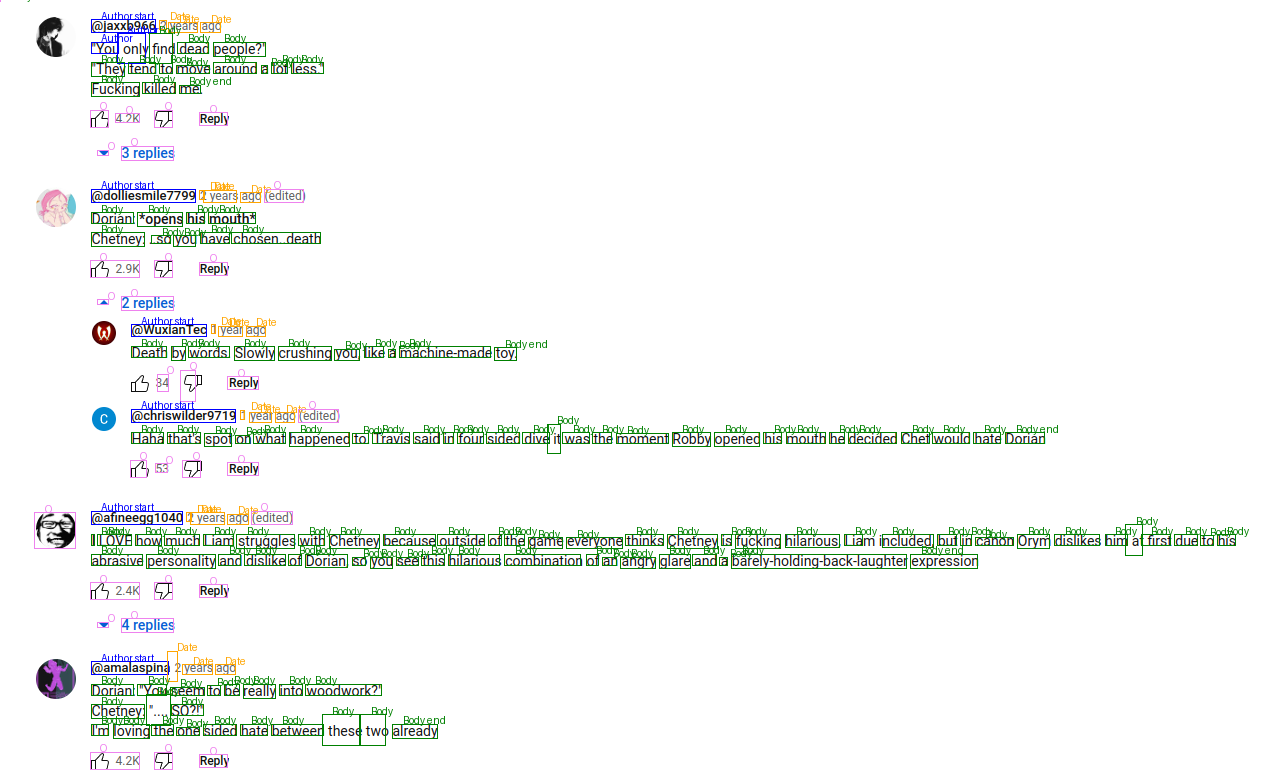

In [101]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

# def iob_to_label(label):
#     label = label[2:]
#     if not label:
#       return 'other'
#     return label

label2color = {'Author':'blue', 'Body':'green', 'Date':'orange', 'O':'violet'}
se_label = {
    0: "",
    1: " start",
    2: " end",
}

for prediction, se_prediction, box in zip(true_predictions, true_start_end_predictions, true_boxes):
    predicted_label = prediction # iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label + se_label[se_prediction], fill=label2color[predicted_label], font=font)

image

In [147]:

processor = LayoutLMv2ImageProcessor.from_pretrained("microsoft/layoutlmv2-base-uncased")
encoding = processor(
    image, return_tensors="pt"
)  # you can also add all tokenizer parameters here such as padding, truncation
print(encoding.keys())

dict_keys(['pixel_values', 'words', 'boxes'])


In [148]:
print(encoding.words)

[['@jaxxb966', '2', 'years', 'ago', '"You', 'only', 'find', 'dead', 'people?”', '"They', 'tend', 'to', 'move', 'around', 'a', 'lot', 'less”', 'Fucking', 'killed', 'me.', '1', '42k', 'GI', 'Reply', '+', '3replies', '@dolliesmile7799', '2', 'years', 'ago', '(edited)', 'Dorian:', '*opens', 'his', 'mouth*', 'Chetney:', '..s0', 'you', 'have', 'chosen..death', '£429', 'DB', 'reply', '=', '2replies', '@WuxianTee', '1', 'year', 'ago', 'Death', 'by', 'words.', 'Slowly', 'crushing', 'you,', 'like', 'a', 'machine-made', 'toy.', '4', 'GP', 'Reply', '@chriswilder9719', '1', 'year', 'ago', '(edited)', 'Haha', "that's", 'spot', 'on', 'what', 'happened', 'to.', 'Travis', 'said', 'in', 'four', 'sided', 'dive', 'it', 'was', 'the', 'moment', 'Robby', 'opened', 'his', 'mouth', 'he', 'decided', 'Chet', 'would', 'hate', 'Dorian', '1', '3', 'Gl', 'Reply', '@afineegg1040', '2', 'years', 'ago', '(edited)', '&', '|', 'LOVE', 'how', 'much', 'Liam', 'struggles', 'with', 'Chetney', 'because', 'outside', 'of', 'the